# Introduction
----
- this is a practise exercise to learn the workings of modern transformers used in LLMs
- I followed the Karpathy's lectures on YouTube and made some changes as needed (for better efficiency)

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(42)

In [3]:
from dataclasses import dataclass

@dataclass
class config:
    block_size = 8 ##context window
    batch_size = 4 

# Reading the input text

In [12]:
file_path = r'/kaggle/input/tiny-shakespeare-karpathys-repo/tiny_shakespeare.txt'
with open(file_path,'r') as f:
    text = f.read()
print(text[:100])
print('='*10)
print(f'Length of the dataset (all the characters):{len(text)}')

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You
Length of the dataset (all the characters):1115394


## Creating a vocabulary from the text
- here karpathy used the set() constructor, which is the most efficient approach 

In [13]:
characters = sorted(set(text)) ##takes out all the unique characters and sorts it, returning a list
vocabulary_size = len(characters)

print(f'Size of vocabulary: {vocabulary_size}')
vocab = ''.join(characters)
print('Vocabulary:',vocab)

Size of vocabulary: 65
Vocabulary: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


## Tokenizing the text
- we are building a character level model, for which we'll first start with a lookup table for charcters -> index and inverse lookkup table for index -> characters
- 

In [14]:
ch2idx = {ch:idx for idx,ch in enumerate(characters)}
idx2ch = {idx:ch for idx,ch in enumerate(characters)}

def encode(text:str):
    return [ch2idx[ch] for ch in text]

def decode(ids:list):
    return ''.join([idx2ch[idx] for idx in ids])

example = 'My name is Harikesh'
print(
    f'Input: {example}',
    '\n',
    f'Len of Input: {len(example)}'
    '\n'
    f'Output(encoded): {encode(example)}'
    '\n'
    f'Length of Encoded output: {len(encode(example))}'
)

Input: My name is Harikesh 
 Len of Input: 19
Output(encoded): [25, 63, 1, 52, 39, 51, 43, 1, 47, 57, 1, 20, 39, 56, 47, 49, 43, 57, 46]
Length of Encoded output: 19


In [15]:
##creating the encoded representation of all the data in a tensor
data = torch.tensor(encode(text),dtype=torch.long)
print(data.shape)

torch.Size([1115394])


## Splitting the data in train and val
- here we can't use a random split, because the text follows a semantic order which has to be preserved if we want our model to learn to generate text like Shakespeare
- we'll use the first 90% data for training and rest 10% for validation

In [16]:
n = int(0.9*len(data))

train_data = data[:n]
val_data = data[n:]

### Training Philosophy
- any chunk of data with size 'd' that is sampled from the train data has 'd' number of training examples for the model
- starting from the first character, we train the model to predict second then with the first two, the third and so on till the 'd-1'th element which is used to predict the d'th character
- here the choice to take context size as 'd' is freely available to the user, with higher values of d requiring more compute

In [17]:
##example
X = train_data[:config.block_size+1]
y = train_data[1:config.block_size+1]

for t in range(config.block_size):
    context = X[:1+t]
    label = y[t]
    print(f'for context: {context} -> {label}')

for context: tensor([18]) -> 47
for context: tensor([18, 47]) -> 56
for context: tensor([18, 47, 56]) -> 57
for context: tensor([18, 47, 56, 57]) -> 58
for context: tensor([18, 47, 56, 57, 58]) -> 1
for context: tensor([18, 47, 56, 57, 58,  1]) -> 15
for context: tensor([18, 47, 56, 57, 58,  1, 15]) -> 47
for context: tensor([18, 47, 56, 57, 58,  1, 15, 47]) -> 58


### A note on generating the batch
- karpathy's method randomly samples (batch_size,block_size) sample vectors from the input text
- this stocasticity means that we may or may not use the whole dataset in training, while it maintains the IID assumptions and will be very beneficials for preventing overfitting there are other better ways to do it (in production)

In [18]:
def get_batch(data,context_window=config.block_size,batch_size=config.batch_size):
    idx = torch.randint(len(data)-context_window,(batch_size,)) 
    X = torch.stack([data[i:i+context_window] for i in idx])
    y = torch.stack([data[i+1:i+context_window+1] for i in idx])
    return X,y

xb,yb = get_batch(train_data)

# BiGram Language Model
- this model effictively uses the statistical approach of calculating all the bigrams from the input text and arranging them in a table where rows and columns are the first and second character of the bigrams and the intersecting cell is the count of how many times the column character follows the row charater in the text
- in PyTorch we can implement this using the nn.Embedding() layer which createst a table of (vocab_size,vocab_size) assigning random numbers in the cells and upon training we hope that the values in these cells approach the count (normalized over the rows) in the statistical table approach

In [19]:
# %%writefile bigram.py
class Bigram(nn.Module):
    def __init__(self,vocab_size):
        super().__init__()
        self.lookup_table = nn.Embedding(vocab_size,vocab_size)
    def forward(self,idx,labels=None):
        logits = self.lookup_table(idx) #(B,T,C) -> (4,8,65)

        if labels is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T,C)
            labels = labels.view(B*T)
            loss = F.cross_entropy(logits,labels)
        return logits,loss
        
    def generate(self,idx,max_length):
        ##idx is (B,T) for batch and timesteps of the input context
        for _ in range(max_length-1):
            logits,loss = self(idx[:,-1])
            # logits = logits[:,:]
            probs = F.softmax(logits,dim=-1)
            idx_next = torch.multinomial(probs,num_samples=1)
            idx = torch.cat([idx,idx_next],dim=1)
        return idx

## Testing Untrained Bigram Model

In [20]:
##testing untrained bigram model
bigram_model = Bigram(vocab_size=vocabulary_size)
logits,loss = bigram_model(xb,yb)

input_context = torch.zeros((1,1),dtype=torch.long)
outputs = bigram_model.generate(input_context,100).squeeze(0).tolist()
print(len(outputs))
print(decode(outputs))

100

cfYCDRUZsYBsA?Y?vgB!ZWOEiAoezL:q&Avufr?gSGdWrp&Bxt-R?wo'TYhBChdIC-RDaRmEGENyouVg'UjyQNyQSpZUVeN:BZq


## Training the BiGram Model

In [61]:
optimizer = torch.optim.AdamW(bigram_model.parameters(),lr=1e-3)

batch_size=8

for steps in range(10000):
    optimizer.step()
    xb,yb = get_batch(train_data)

    logits,loss = bigram_model(xb,yb)

    loss.backward()
    optimizer.step()

    if steps%1000 == 0:
        print(loss.item())

input_context = torch.zeros((1,1),dtype=torch.long)
outputs = bigram_model.generate(input_context,100).squeeze(0).tolist()
# print(len(outputs))
print(decode(outputs))

2.708622932434082
2.6894116401672363
2.176974058151245
2.289198160171509
4.675192832946777
2.432370662689209
2.631892442703247
2.386826753616333
2.491130828857422
2.5769729614257812

G BENTCLOMNCI linn, onofeviapearb prstrde cooned insue'me wak hrs dotor LAno merareathabed hepe ar 


# Understanding Attention Mechanism -  the **matrix multiplication trick**
- before writing any self-attention block we need to understand what attention does
- here we used a toy example to understand what attention does in practice

In [21]:
## a toy vector which represents the actual tensors in a language model 
B,T,C = 4,8,2
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

- currently the T tokens in each batch are not communicating with each other, in the BiGram model only the current token was taken to look forward in the lookup table based on the probability
- but we need them to interact in a certain way, to establish this interaction we begin with the simplest form of interaction
- **Averaging all the tokens in channels till 't' where t <= T for each batch**

## 1. Using the naive loop

In [22]:
##code to do this operation also called BOW(bag of words)
xbow = torch.zeros((B,T,C))
for batch_idx in range(B):
    for time_step in range(T):
        xprev = x[batch_idx,:time_step+1]
        xbow[batch_idx,time_step] = torch.mean(xprev,0)

x[0],xbow[0]

(tensor([[ 1.0652,  1.4098],
         [ 1.6263,  0.0065],
         [ 0.0182,  0.1661],
         [ 0.8874,  0.1085],
         [ 1.3757, -0.2378],
         [ 0.6894, -0.2131],
         [-0.2155,  1.4510],
         [-0.3396, -1.6361]]),
 tensor([[1.0652, 1.4098],
         [1.3458, 0.7081],
         [0.9032, 0.5274],
         [0.8993, 0.4227],
         [0.9946, 0.2906],
         [0.9437, 0.2066],
         [0.7781, 0.3844],
         [0.6384, 0.1318]]))

## 2. Using the matrix multiplication trick with **tril** or **triu**

In [23]:
mask = torch.tril(torch.ones(3,3))
mask = mask/torch.sum(mask,1,keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = mask@b

print(f'mask=\n{mask}')
print('='*5)
print(f'a:\n{b}')
print('='*5)
print(f'mask @ a:\n{c}')

mask=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
=====
a:
tensor([[8., 8.],
        [5., 4.],
        [9., 1.]])
=====
mask @ a:
tensor([[8.0000, 8.0000],
        [6.5000, 6.0000],
        [7.3333, 4.3333]])


### Using this trick to create a similar matrix 
- here the mask (T,T) when matirx multiplied to x (B,T,C) by the rules of brodcasting mask is brodcasted to (B,T,T)
- and like the previous cell all the matrices in channels are averaged 

In [24]:
mask = torch.tril(torch.ones(T,T))
mask = mask/torch.sum(mask,1,keepdim=True)

c = mask@x
xbow[0],c[0]

(tensor([[1.0652, 1.4098],
         [1.3458, 0.7081],
         [0.9032, 0.5274],
         [0.8993, 0.4227],
         [0.9946, 0.2906],
         [0.9437, 0.2066],
         [0.7781, 0.3844],
         [0.6384, 0.1318]]),
 tensor([[1.0652, 1.4098],
         [1.3458, 0.7081],
         [0.9032, 0.5274],
         [0.8993, 0.4227],
         [0.9946, 0.2906],
         [0.9437, 0.2066],
         [0.7781, 0.3844],
         [0.6384, 0.1318]]))

## 3. Using the softmax and mask filling approach to make learnable parameters
- here we will make the 'wei' matrix change based on the data
- implementing that change in next step

In [25]:
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril==0,float('-inf'))

wei = F.softmax(wei,dim=1)

xbow3 = wei@x

torch.allclose(xbow,xbow3)

True

## 4. Defining how to create the wei matrix from data dependent parameters
- the output is aggregated per head (16 here)
- usually this is done for multiple head sizes which add upto C

In [40]:
head_size = 16
key = nn.Linear(C,head_size,bias=False)
query = nn.Linear(C,head_size,bias=False)
value = nn.Linear(C,head_size,bias=False)

##defining wei matrix 

k = key(x) ## (B,T,C)*(C,h) -> (B,T,C)*(B,C,h) => (B,T,h)
q = query(x) ## (B,T,h)
v = value(x) ## (B,T,h)

wei = q@k.transpose(-2,-1) ## (B,T,h)*(B,T,h) -> (B,T,h)*(B,h,T) => (B,T,T)
wei = wei.masked_fill(tril==0,float('-inf'))
n_wei = wei
wei = F.softmax(wei,dim=2)

# xbow_self_attention = wei@x
xbow_self_attention = wei@v ## (B,T,h)
##instead of directly applying softmax to x we apply it to value(x)

print(xbow_self_attention.shape)
# print(torch.allclose(xbow_self_attention,xbow))

torch.Size([4, 8, 16])


In [42]:
n_wei[0],wei[0]

(tensor([[-1.1803,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
         [-1.5551, -2.1457,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
         [-0.0365, -0.1489,  0.0055,    -inf,    -inf,    -inf,    -inf,    -inf],
         [-0.8607, -1.2499, -0.0190, -0.6852,    -inf,    -inf,    -inf,    -inf],
         [-1.2875, -1.6320, -0.0441, -0.9069, -1.3427,    -inf,    -inf,    -inf],
         [-0.6344, -0.7472, -0.0255, -0.4186, -0.6070, -0.2945,    -inf,    -inf],
         [ 0.0390, -0.8083,  0.0581, -0.3986, -0.7821, -0.4299,  0.6942,    -inf],
         [ 0.5128,  1.6782, -0.0505,  0.8720,  1.5211,  0.8015, -0.8281,  0.3316]],
        grad_fn=<SelectBackward0>),
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.6435, 0.3565, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3405, 0.3043, 0.3552, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1927, 0.1306, 0.4471, 0.2297, 0.0000, 0.0000, 0.0000, 0.0000],

### Note on attention
- attention is just a connection mechanism which makes independent entities to communicate between them that is to say make them transfer their information among themselves
- the particular attention mechanism discussed here is **self-attented decoder** where only the past nodes talk with each other and all the k,q and v matrices come from same tensor
- there are multiple types of attentions, the one most adjacent to this type of attention is encoder architecture (used in BERT) where instead of mask filling we allow all the tokens to talk to each other at one time

## 4.1 Addressing the variance propogation in attention
- the weight matrix formed from k and query multiplication carries a variance in the order of $h^2$

In [35]:
k.var(),n_wei.var(),(n_wei*(head_size)**-0.5).var()

(tensor(0.3436, grad_fn=<VarBackward0>),
 tensor(2.9703, grad_fn=<VarBackward0>),
 tensor(0.1856, grad_fn=<VarBackward0>))

# Final Model Implementation and Training

## Utilities - Tokenizer, Vocabulary

In [ ]:
import torch
torch.manual_seed(42)

def get_batch(data,context_window=8,batch_size=8,DEVICE='cpu'):
    idx = torch.randint(len(data)-context_window,(batch_size,)) 
    X = torch.stack([data[i:i+context_window] for i in idx])
    y = torch.stack([data[i+1:i+context_window+1] for i in idx])
    X = X.to(DEVICE)
    y = y.to(DEVICE)
    return X,y

@torch.no_grad()
def estimate_loss(model,train_data,val_data,eval_iters,context_windo,batch_size,device):
    out = {}
    splits = ['train','val']
    model.eval()
    for idx,data in enumerate([train_data,val_data]):
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X,y = get_batch(data=data,context_window=context_windo,batch_size=batch_size,DEVICE=device)
            _,loss = model(X,y)
            losses[k] = loss
        out[splits[idx]] = losses.mean()
    model.train()
    return out

class custom_tokenizer():
    def __init__(self,data_path) -> None:
        self.data_path = data_path
        self.load()

    def load(self):
        try:
            with open(self.data_path,'r') as f:
                text = f.read()
        except Exception as e:
            print(str(e))

        self.data = text
        self.vocab = sorted(set(text))
        self.ch2idx = {ch:idx for idx,ch in enumerate(self.vocab)}
        self.idx2ch = {idx:ch for idx,ch in enumerate(self.vocab)}
    
    def encode(self,text:str):
        return [self.ch2idx[ch] for ch in text] 
    
    def decode(self,ids:list):
        return ''.join([self.idx2ch[idx] for idx in ids])

    def _size_(self):
        return len(self.vocab)
    
    def get_coded_data_split(self):
        data_tensor = torch.tensor(self.encode(self.data))
        n = int(0.9*len(data_tensor))
        train,val = data_tensor[:n],data_tensor[n:]
        return train,val

import math
def get_lr(it,config):
    # 1. Linear Warmup Phase
    if it < config.warmup_iters:
        return config.max_lr * (it + 1) / config.warmup_iters
    
    # 2. If we go past max_iters, just return min_lr
    if it > config.max_iters:
        return config.min_lr
    
    decay_ratio = (it - config.warmup_iters) / (config.max_iters - config.warmup_iters)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # ranges 0..1
    return config.min_lr + coeff * (config.max_lr - config.min_lr)
    

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass

class FeedForward(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.embed,4*config.embed),
            nn.ReLU(),
            nn.Linear(4*config.embed,config.embed),
            nn.Dropout(config.dropout)
        )
    def forward(self,x):
        return self.net(x)

class causalAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        assert config.embed % config.n_heads == 0
        self.c_attn = nn.Linear(config.embed,3*config.embed,bias=False)
        self.proj = nn.Linear(config.embed,config.embed,bias=False)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_heads = config.n_heads
        self.n_embed = config.embed
    def forward(self,x):
        B,T,C = x.shape

        kqv = self.c_attn(x) ## x(B,T,C) -> kqv (B,T,3*C)

        k,q,v = kqv.split(self.n_embed,dim=2) ## each matrix has dimension (B,T,C)

        k = k.view(B,T,self.n_heads,C // self.n_heads).transpose(1,2) ## k(B,T,C) -> (B,T,n_heads,head_size) -> (B,n_heads,T,head_size)
        q = q.view(B,T,self.n_heads,C // self.n_heads).transpose(1,2) ## q(B,T,C) -> (B,T,n_heads,head_size) -> (B,n_heads,T,head_size)
        v = v.view(B,T,self.n_heads,C // self.n_heads).transpose(1,2) ## v(B,T,C) -> (B,T,n_heads,head_size) -> (B,n_heads,T,head_size)

        ##attention calculation for each head we want (T,head_size) which we'll concatenate

        wei = q @ k.transpose(-2,-1) * (k.shape[-1]**-0.5) ## wei: (B,n_heads,T,T)
        trill = torch.tril(torch.ones(T,T,device=x.device)).view(1,1,T,T)
        wei = wei.masked_fill(trill == 0,float('-inf'))

        wei = F.softmax(wei,dim=-1)
        wei = self.attn_dropout(wei)
        
        y = wei@v

        y = y.transpose(1,2).contiguous().view(B,T,C)

        out = self.proj(y)
        out = self.resid_dropout(out)
        return out

class Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.sa = causalAttention(config)
        self.ffwd = FeedForward(config)

        self.ln1 = nn.LayerNorm(config.embed)
        self.ln2 = nn.LayerNorm(config.embed)
    
    def forward(self,x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class NanoGPT(nn.Module):
    def __init__(self, config, vocab_size): # Added config
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, config.embed)
        self.position_embedding_table = nn.Embedding(config.block_size, config.embed)
        self.dropout = nn.Dropout(config.dropout)
        # 3. THE BLOCKS: A stack of Transformer Blocks (Sequential is fine here)
        self.blocks = nn.Sequential(*[
            Block(config) for _ in range(config.n_layer)
        ])
        
        # 4. FINAL LAYER NORM: Standard Pre-Norm practice
        self.ln_f = nn.LayerNorm(config.embed)
        
        # 5. LM HEAD: Projects from embedding dim back to vocab size
        self.lm_head = nn.Linear(config.embed, vocab_size)

        self.block_size = config.block_size

    def forward(self, idx, labels=None):
        B, T = idx.shape

        pos_idx = torch.arange(T, device=idx.device) 
        
        tok_emb = self.token_embedding_table(idx) # (B, T, C)
        pos_emb = self.position_embedding_table(pos_idx) # (T, C)
        
        x = tok_emb + pos_emb # (B, T, C)
        x = self.dropout(x)
        x = self.blocks(x) # (B, T, C)
        
        x = self.ln_f(x) # (B, T, C)
        
        logits = self.lm_head(x) # (B, T, vocab_size)

        if labels is None:
            loss = None
        else:
            # Reshape for Cross Entropy (Standard PyTorch requirement)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            labels = labels.view(-1)
            loss = F.cross_entropy(logits, labels)

        return logits, loss

    def generate(self, idx, max_length):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_length):
            # NEW: Crop context to the last block_size tokens
            # If idx is longer than block_size, position embeddings will crash!
            idx_cond = idx[:, -self.block_size:]
            
            # Get the predictions
            logits, loss = self(idx_cond)
            
            # Focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            
            # Append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


In [14]:
import torch
from tqdm.notebook import tqdm, trange 
from dataclasses import dataclass

@dataclass
class config:
    n_layer = 6
    block_size = 256
    embed = 384
    n_heads = 6
    batch_size = 64
    dropout = 0.2
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    max_iters_training = 10000
    max_lr = 3e-4        
    min_lr = 3e-5        
    warmup_iters = 100   
    max_iters = max_iters_training 
    eval_iters = 300
    data_path = r'/kaggle/input/tiny-shakespeare-karpathys-repo/tiny_shakespeare.txt'

# 1. Setup Data & Model
tokenizer = custom_tokenizer(data_path=config.data_path)
train_data, val_data = tokenizer.get_coded_data_split()

model = NanoGPT(config, tokenizer._size_()) # Ensure this method returns int
model.to(config.device)

# 2. Setup Optimizer 
optimizer = torch.optim.AdamW(model.parameters(), lr=config.max_lr)
trLoss,valLoss = [],[]

best_metric = float('inf') # Start at infinity so first loss is always "better"
patience = 5               # How many evals to wait before stopping
trigger = 0
print('Starting Training....')

# 3. Training Loop
training_loop = trange(config.max_iters_training, desc='Training') 

for step in training_loop:
    # A. Update Learning Rate
    lr = get_lr(step,config)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    # B. Evaluation (Every eval_iters)
    if step % config.eval_iters == 0 or step == config.max_iters_training - 1:
        losses = estimate_loss(model, train_data, val_data, config.eval_iters, config.block_size, config.batch_size, config.device)
        training_loop.set_postfix(train_loss=losses['train'].item(), val_loss=losses['val'].item(), lr=lr)
        tqdm.write(f"Step {step}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        trLoss.append(losses['train'].item())
        valLoss.append(losses['val'].item())
        if(losses['val'] < best_metric):
            best_metric = losses['val']
            trigger = 0
            torch.save(model.state_dict(),'nanoGPT.pth')
        else:
            trigger+=1

    if trigger > patience:
        print('EARLY STOPPING')
        break

    # C. Training Step
    xb, yb = get_batch(train_data, config.block_size, config.batch_size, config.device)
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True) 
    loss.backward()
    optimizer.step()
    torch.cuda.empty_cache()


# print("Trained model output:\n")
# context = torch.zeros((1, 1), dtype=torch.long, device=config.device)
# print(tokenizer.decode(model.generate(context, 500).squeeze(0).tolist()))

Starting Training....


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Step 0: train loss 4.2476, val loss 4.2447
Step 300: train loss 2.3966, val loss 2.4189
Step 600: train loss 1.9937, val loss 2.0757
Step 900: train loss 1.7502, val loss 1.8946
Step 1200: train loss 1.6093, val loss 1.7822
Step 1500: train loss 1.5114, val loss 1.6998
Step 1800: train loss 1.4448, val loss 1.6520
Step 2100: train loss 1.3908, val loss 1.6010
Step 2400: train loss 1.3554, val loss 1.5812
Step 2700: train loss 1.3217, val loss 1.5587
Step 3000: train loss 1.2899, val loss 1.5321
Step 3300: train loss 1.2646, val loss 1.5340
Step 3600: train loss 1.2446, val loss 1.5176
Step 3900: train loss 1.2222, val loss 1.5104
Step 4200: train loss 1.2065, val loss 1.5018
Step 4500: train loss 1.1860, val loss 1.4953
Step 4800: train loss 1.1716, val loss 1.4887
Step 5100: train loss 1.1553, val loss 1.4817
Step 5400: train loss 1.1417, val loss 1.4849
Step 5700: train loss 1.1305, val loss 1.4871
Step 6000: train loss 1.1171, val loss 1.4791
Step 6300: train loss 1.1027, val loss 1

Text(0.5, 0, 'Evaluation Step')

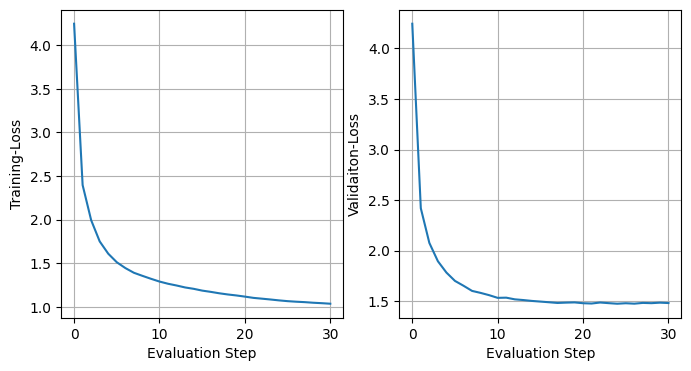

In [17]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(8,4),sharex = True)
ax[0].plot(trLoss)
ax[0].grid()
ax[0].set_ylabel('Training-Loss')
ax[0].set_xlabel('Evaluation Step')
ax[1].plot(valLoss)
ax[1].grid()
ax[1].set_ylabel('Validaiton-Loss')
ax[1].set_xlabel('Evaluation Step')

In [32]:
model = NanoGPT(config,tokenizer._size_())
model.load_state_dict(torch.load(r'/kaggle/working/nanoGPT.pth',map_location=config.device))
model.to(config.device)
context = torch.zeros((1, 1), dtype=torch.long, device=config.device)
model_output = tokenizer.decode(model.generate(context, 10000).squeeze(0).cpu().tolist())

Trained model output:



In [35]:
print(model_output)


Do not because the life on the rebels,
I have deserved with no quite and dargems.
If it be daughter, I sever'd well-been secret
And therefolds sight 't:' be the preciound
That to the Edward blindness, and masks him;
The same our aid, and let perille,
I pleade you banished him: if my loyal,
Doing out an in hour uprincets of pirect
To famish'd opposite thy fall,
We are colours in our daughter's womb in:
'antily, not raged me too, so much show'd her
Undon your counterse must to a father's.

BRUTUS:
O lamentation!
Ere farewell: for well.

SICINIUS:
He come upon, hither
Most abotial.

CORIOLANUS:
Come, that's it face:
What batters it is come to Braught with Laurenca?
Why, what? then, Warwick, and thy war
That makes rapkind by the people
In thee service and cennice myself. Was now
none, fulless, stood issieges, that followers;
these was bed induke, who still, thou knows
is, anon his child: why, I cannight;
Yet therefore have he beet worthip the
sings begue after?

AUTOLYCUS:
This fly, they


In [33]:
output_file = r'/kaggle/working/demo.txt'

with open(output_file,'w') as f:
    f.write(model_output)